In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Dataset import *
from Metric import *
from Model import *
from Preprocess import *
from train import *
from tqdm.auto import trange
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data = pd.read_csv("data/final.csv")

data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
data.head()
m_data = data.copy()
m2_data = data.copy()
patch_data = data.copy()


In [4]:
tst_size = 20
trn, tst = data[:-tst_size], data[-tst_size:]

## Stateful Lstm

In [ ]:
# 변수 초기화

#Lstm
state_input_size = 2     #고정
state_hidden_size = 32
state_output_size = 2     #고정
state_num_layers = 2
state_batch_size = 128

In [ ]:
statefullstm = StatefulLoadData(data,tst_size)
state_trn_scaled, state_tst_scaled = statefullstm.scaling()
#trn_scaled, tst_scaled

In [ ]:
statefulmodel = StatefulLSTM(state_input_size,state_hidden_size,state_output_size,state_num_layers)
statefulmodel.to(device)

In [ ]:
trn_x = torch.tensor(state_trn_scaled[:-1]).split(state_batch_size)
trn_y = torch.tensor(state_trn_scaled[1:]).split(state_batch_size)
tst_y = torch.tensor(state_tst_scaled)

In [ ]:
state_optim = torch.optim.AdamW(statefulmodel.parameters(), lr=0.0001)
p=state_train_epoch(statefulmodel, 1000 , device, zip(trn_x,trn_y), state_optim, tst_y)
#map , filter, zip

In [ ]:
scaler = statefullstm.get_scaler()
prd = scaler.inverse_transform(p.cpu()[:,:1])

In [ ]:
plt.title(f"LSTM (Stateful), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}, R2:{r2_score(prd,tst.to_numpy())}")
plt.plot(tst.Temperature.to_numpy(), label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

In [ ]:
torch.save(statefulmodel.state_dict(), './model/AdamW_0.002_StatefulLstm.pth')

# Stateless Lstm

In [ ]:
stateless_window_size = 64
stateless_input_size = 2
stateless_hidden_size = 32
stateless_output_size = 2
stateless_num_layers = 2

asdf = StatelessLoadData(data, tst_size, stateless_window_size)
stateless_trn_dl , stateless_tst_dl = asdf.scaling()

In [ ]:
statelesslstm = StatelessLSTM(stateless_input_size , stateless_hidden_size , stateless_output_size , stateless_num_layers)
statelesslstm.to(device)

In [ ]:
x,y =next(iter(stateless_trn_dl))
x.shape,y.shape

In [ ]:
optim = torch.optim.AdamW(statelesslstm.parameters(), lr=0.0001)
p2 = stateless_train_epoch(statelesslstm,10,device,stateless_trn_dl,optim,stateless_tst_dl, state_tst_scaled)

In [ ]:
scaler = asdf.get_scaler()
prd = scaler.inverse_transform(p2.cpu())
# prd = p.cpu()

plt.title(f"LSTM (Look-back window), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}, R2:{r2_score(prd,tst.to_numpy())}")
plt.plot(tst.to_numpy()[:,:1], label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

# Single ANN

In [ ]:
# dataset params
single_lookback_size = 24
single_forcast_size = 4 
single_batch_size = 32

# model params
single_d_in = 24
single_d_out = 4 
single_d_hidden = 512

anndataset = ANNLoadData(m_data,single_lookback_size,single_forcast_size,tst_size,single_batch_size)

single_trn_dl , single_tst_dl, single_trn_ds = anndataset.scaling()

In [ ]:
singleann = Net(single_d_in,single_d_out,single_d_hidden)

In [ ]:
x, y = next(iter(single_trn_dl))

x.shape, y.shape

In [ ]:
singleann.to(device)
optim = torch.optim.AdamW(singleann.parameters(), lr=0.0001)
p3 = train_epoch(singleann , 500 , device, single_trn_dl, optim, single_trn_ds, single_tst_dl)

In [ ]:
singleann.eval()
with torch.inference_mode():
  x, y = next(iter(single_tst_dl))
  x, y = x.to(device), y.to(device)
  p = singleann(x)

scaler = anndataset.get_scaler()
y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

res_dict = {}

plt.title(f"Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(9,512,4)': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})

In [ ]:
# 장기예측
window_size = single_lookback_size
prediction_size = single_forcast_size
preds = []
tst_data  = data [-tst_size :]

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
singleann.to(device)

# print(type(x), type(y))
x, y = single_trn_ds[len(single_trn_ds)-1]

for _ in range(tst_size):
  #print(x.shape, y.shape)
  y=y.squeeze()
  #print(x.shape, y.shape)

  x = np.concatenate([x,y])[-window_size:]
  #x = x.flatten()
  #y = y.flatten()
    
  x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
  #y = net(torch.tensor(x, dtype=torch.float32).to(device)) # your model
  y=singleann(x_tensor)
  y = y.detach().cpu().numpy()
  y= y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)

preds = np.concatenate(preds, axis=0)
preds = scaler.inverse_transform(preds).squeeze()
#print(preds.shape)
preds = preds[:,0]
#print(preds.shape)

mape2 = mape(preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
df = pd.DataFrame({"ANN_long": preds}, index=tst_data.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

# Multichannel ANN

In [ ]:
#Multi Load Data
multi_lookback_size = 20
multi_forecast_size = 10
multi_batch_size = 32
#multi_window_size = 24
# prediction_size = 4 여기 사용안하는것 같에요

# Multi model
multi_input_size = multi_lookback_size   #고정
multi_hidden_size = 512
multi_output_size = multi_forecast_size     #고정
multi_channel_size = 3

In [ ]:
#m_data = data.copy()
m2_data['rolling_mean'] = m2_data.rolling(12).mean()
m2_data['diff1'] = m2_data['Temperature'].diff(1)
m2_data = m2_data.dropna()

multidata = MultiANNLoadData(m2_data,multi_lookback_size,multi_forecast_size,tst_size,multi_batch_size)
multi_trn_dl, multi_tst_dl , multi_trn_ds = multidata.scaling()

In [ ]:
multimodel = NetMulti(multi_lookback_size,multi_output_size,multi_hidden_size,multi_channel_size)

- 40개월   ex) 60을 보고 40을 예측  /  1개월씩 40을 예측  /  4개월씩 10번
- 목표를 설정하고 그것을 이루기 위해 시도한 방법들 소개!

In [ ]:
multimodel.cuda()

optim = torch.optim.AdamW(multimodel.parameters(), lr=0.0001)
train_epoch(multimodel,1000,device,multi_trn_dl,optim,multi_trn_ds, multi_tst_dl)

In [ ]:
torch.save(multimodel.state_dict(), 'model/AdamW_lookback20_forecast10_multichannel.pth')

# 단기

In [ ]:
scaler = multidata.get_scaler()
res_dict = {}

multimodel.eval()
multimodel.to('cuda')
with torch.inference_mode():
  x, y = next(iter(multi_tst_dl))
  #print(y.shape) #17,4,3
  y=y.reshape(-1,multi_channel_size)
  y=scaler.inverse_transform(y.cpu().numpy())
  y=y.reshape(-1,multi_forecast_size,multi_channel_size)
  x, y = x.flatten(1), y[:,:,0] #17,4    0번째 채널을 뽑고있다.

  x = x.to('cuda')
  #p = Multinet(x)[:,:,0]
  p = multimodel(x)
  #print(p.shape)
  p = p.reshape(-1,multi_channel_size)
  p=p.cpu()
  p=scaler.inverse_transform(p.numpy())
  #print(p.shape)
  p = p.reshape(-1,multi_forecast_size,multi_channel_size)

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])
#print(y,p)
#print(y.shape,p.shape)
p = p[:,0]
#inverse_preds = scaler.inverse_transform(p.reshape(-1,3))


plt.title(f"Multi Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(9*2, 512, 4)': {'MAPE':mape(p,y), 'MAE':mae(p,y),  'R2':r2_score(p,y)}})

# 장기

In [ ]:
# 장기예측
window_size = multi_lookback_size
prediction_size = multi_forecast_size
preds = []
multimodel.to(device)

# print(type(x), type(y))
x, y = multi_trn_ds[len(multi_trn_ds)-1]
#print(y)
#print(x.shape , y.shape)

In [ ]:
preds = []

for i in range(tst_size):
  y = y.squeeze()
  # print(i, x.shape, y.shape)
  x = np.concatenate([x,y])[-window_size:]
    
  x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
  # print(x_tensor.shape)
  y = multimodel(x_tensor)
  # print(y.shape)
  y = y.detach().cpu().numpy()
  # y = y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)
  # print(i, x.shape, y.shape)

preds = np.concatenate(preds, axis=0)
inverse_preds = scaler.inverse_transform(preds.reshape(-1,3)).reshape(-1,multi_forecast_size,3)

final_preds = inverse_preds[:, 0,0]
print(final_preds.shape)

mape2 = mape(final_preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(final_preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(final_preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
df = pd.DataFrame({"ANN_long": final_preds}, index=tst.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

# PatchTST

In [15]:
#test_size = 20
#초기화
#patch_size = 4 #고정
#(batch, n_patchs, patch_length)
#근까 patch length가 patch size랑 같은말아님?????
patch_length = 16 #고정
n_patch = 4
n_token = 64   #조정
patch_batch_size = 32
patch_model_dim = 128 #고정
patch_num_heads = 16   #고정
patch_num_layers = 3   #고정
patch_output_dim = tst_size  #고정

In [16]:
patchdata = PatchLoadData(patch_data, n_patch, patch_length, tst_size, patch_batch_size)
patch_trn_dl , patch_tst_dl, patch_trn_ds = patchdata.scaling()

In [17]:
patchmodel = PatchTST(n_patch, patch_length, patch_model_dim, patch_num_heads, patch_num_layers, patch_output_dim)
patchmodel.cuda()

PatchTST(
  (patch_embedding): Linear(in_features=16, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=512, out_features=20, bias=True)
)

In [18]:
a,b = next(iter(patch_trn_dl))
a.shape,b.shape

(torch.Size([32, 4, 16]), torch.Size([32, 20]))

In [19]:
optim = torch.optim.AdamW(patchmodel.parameters(), lr=0.0001)
train_epoch(patchmodel,100,device,patch_trn_dl,optim,patch_trn_ds, patch_tst_dl)

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([[0.7684, 0.7410, 0.7402, 0.7336, 0.7491, 0.7507, 0.7662, 0.7627, 0.7626,
         0.7627, 0.7618, 0.7695, 0.7508, 0.7317, 0.7262, 0.7513, 0.7611, 0.7611,
         0.7882, 0.7977]], device='cuda:0')

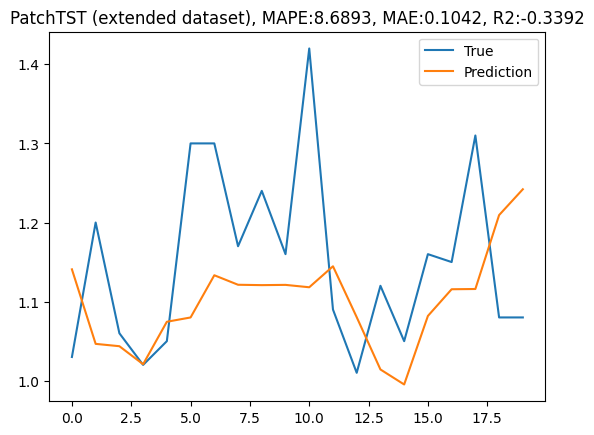

In [20]:
scaler = patchdata.get_scaler()

patchmodel.eval()
with torch.inference_mode():
  x, y = next(iter(patch_tst_dl))
  x, y = x.cuda(), y.cuda()
  p = patchmodel(x)

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"PatchTST (extended dataset), MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

In [27]:
window_size = n_patch * patch_length
eval = trn[-window_size:]
eval = eval.to_numpy()

last8 = eval[-1]
eval = eval.squeeze()
print(eval.shape)
eval_concat = np.concatenate([eval, last8*np.ones(8,dtype=np.float32)])

(64,)


In [31]:
eval_concat.shape
eval_concat
x = np.array([eval_concat[i*8:(i+2)*8] for i in range(4)])

In [33]:
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y=patchmodel(x_tensor)

y

tensor([[0.7632, 0.7111, 0.7379, 0.7265, 0.7276, 0.7487, 0.7175, 0.6971, 0.6456,
         0.6395, 0.6641, 0.6934, 0.7186, 0.6851, 0.7178, 0.7569, 0.7621, 0.7722,
         0.7533, 0.7549]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [36]:
y = y.detach().cpu().numpy()
scaler = patchdata.get_scaler()
preds = scaler.inverse_transform(y).squeeze()

In [37]:
preds

array([1.1231081 , 0.94318587, 1.0355889 , 0.99647665, 1.0002145 ,
       1.072933  , 0.9653207 , 0.895155  , 0.7174816 , 0.69611293,
       0.7811422 , 0.88217056, 0.96912706, 0.85368234, 0.96651137,
       1.1011832 , 1.1190937 , 1.1542482 , 1.0888666 , 1.0944935 ],
      dtype=float32)

MAPE:  15.513314857914034
MAE:  0.18884203112125397
R2_Score:  -4.5057941430717054


<Axes: xlabel='YearMonth'>

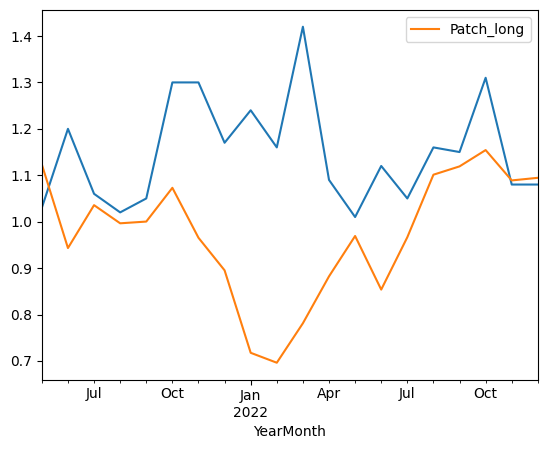

In [38]:
mape2 = mape(preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 장기예측 plot
#plt.title(f"PatchTST (extended dataset), MAPE:{mape(preds,data.Temperature[-20:].to_numpy()):.4f}, MAE:{mae(preds,data.Temperature[-20:].to_numpy()):.4f}, R2:{r2_score(preds,data.Temperature[-20:].to_numpy())(p,y):.4f}")
df = pd.DataFrame({"Patch_long": preds}, index=tst.index)
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

In [ ]:
torch.save(patchmodel.state_dict(), 'model/n_patch12_patchTST.pth')